In [7]:
%load_ext autoreload

In [8]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib import font_manager
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys
import torch
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import *

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *

plt.style.use('../../sci_style.py')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [60]:
def set_smallest_eigenvalue_real_part(A,lam):

    #lam is the desired maximum eigenvalue
    assert lam < 0, print('Eigenvalue must be negative')

    #get current eigenvalues
    e,v = np.linalg.eig(A)
    largest_eig = np.max(np.real(e))
    I = np.eye(len(e))
  
    #return scaled 
    return A - largest_eig*I + lam*I

def do_one_sde_run(n, lam_awake, lam_anesthesia, awake = 1, random_seed=42):

    np.random.seed(random_seed)

    A = np.random.normal(0,1/np.sqrt(n),(n,n))

    if awake == 1:
        #pick the stability parameter
        lam = lam_awake

        # Define the Weiner process    
        dW = np.sqrt(dt) * np.random.randn(N,n)

        #define systems matrix
        A_awake = set_smallest_eigenvalue_real_part(A,lam)

    else:

        lam = lam_anesthesia

        dW = np.sqrt(dt) * np.random.randn(N,n)

        A_anesthesia = set_smallest_eigenvalue_real_part(A,lam)


    # Define the function f(x)
    def f(x,lam):
        if awake == 1:
            return A_awake @ x
        else:
            return A_anesthesia @ x


    # Define the function g(x)
    def g(x):
        return 1

    # Initialize the x array
    x = np.zeros((N,n))
    x[0] = np.zeros(n)

    # Simulate the stochastic differential equation
    for i in range(1, N):
        x[i] = x[i-1] + f(x[i-1],lam) * dt + g(x[i-1]) * dW[i]

    return x

In [61]:
class ParameterGrid:
    def __init__(self, window_vals, matrix_size_vals, r_vals):
        self.window_vals = window_vals
        self.matrix_size_vals = matrix_size_vals
        self.r_vals = r_vals

In [62]:
use_torch = True
device = 'cuda'

In [63]:
# Define the parameters
# N = int(1e5)
N = 20000
n = 100
T = 40.0
dt = T / N
x0 = 0.0

NUM_RUNS = 1

# lams = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]
lams = [-0.1]

# parameter_grid = ParameterGrid(
#     window_vals=np.array([10000]),
#     matrix_size_vals=np.array([10, 20, 50, 100, 200, 300, 500, 750, 1000]),
#     r_vals=np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000])
# )

parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([10, 20, 50]),
    r_vals=np.array([3, 5, 10, 25, 50])
)


prediction_time = 5000
transient = 2000

num_samples = 10

for i in range(NUM_RUNS):
    print("="*40)
    print(f"RUN {i}")
    print("="*40)

    print("Simulating...")
    trajs = {}
    for lam in lams:
        x_1 = do_one_sde_run(n, lam_awake = lam, lam_anesthesia = 0, awake = 1, random_seed=42 + i)
        trajs[lam] = x_1
    #         plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam}$')
    #     plt.legend()
    #     plt.show()
    indices = np.random.choice(np.arange(n), num_samples, replace=False)
    for key in trajs.keys():
        trajs[key] = trajs[key][:, indices]
    print("Simulated!")

    signals = trajs

    mean_stab_curve = True
    true_vals = lams
    keys = np.array(lams)
    key_inds = np.arange(len(lams))

    print("Computing DeLASE...")
    results = []
    iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))
    for window in parameter_grid.window_vals:
        for matrix_size in parameter_grid.matrix_size_vals:
            delases = {}
            exp_variances = {}
    #         train_signals = []
            test_signals = {}
            for key, signal in signals.items():
                train_signal = signal[transient:transient + window]
                test_signal = signal[transient + window:transient + window + prediction_time]
                delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, device=device)
                delase.DMD.compute_hankel()
                delase.DMD.compute_svd()
                delase.to('cpu')
                # if use_torch:
                #     exp_variances[key] = delase.cumulative_explained_variance.cpu().double()
                # else:
                #     exp_variances[key] = delase.cumulative_explained_variance
                delases[key] = delase
    #             train_signals.append(train_signal)
                test_signals[key] = test_signal
            for r in parameter_grid.r_vals:
                if r <= np.min([delase.n*delase.n_delays for delase in delases.values()]):
                    stab_curves = {}
                    AICs = {}
                    for key, delase in delases.items():
                        delase.to('cuda')
                        delase.DMD.compute_havok_dmd(rank=r)
                        delase.get_stability(max_freq=500, max_unstable_freq=125)

                        AICs[key] = compute_AIC(delase, test_signals[key])
                        if use_torch:
                            stab_curves[key] = delase.stability_params.cpu()
                        else:
                            stab_curves[key] = delase.stability_params

                    # if use_torch:
                    #     exp_variances = np.array([delase.cumulative_explained_variance[r-1].cpu().numpy() for delase in delases.values()])
                    # else:
                    #     exp_variances = np.array([delase.cumulative_explained_variance[r-1] for delase in delases.values()])

                    results.append(dict(
                        window=window,
                        matrix_size=matrix_size,
                        r=r,
                        exp_variances=exp_variances,
                        AICs=AICs,
                        stab_curves=stab_curves,
                    ))

                iterator.update()
    iterator.close()

    results = pd.DataFrame(results)
    results_dict = {}
    for key in lams:
        ret_temp = results.copy()
        ret_temp = ret_temp.drop('AICs', axis=1)
        ret_temp = ret_temp.drop('stab_curves', axis=1)
        ret_temp = ret_temp.drop('exp_variances', axis=1)
        ret_temp['AIC'] = results.AICs.apply(lambda x: x[key])
        ret_temp['stab_curves'] = results.stab_curves.apply(lambda x: x[key])
        ret_temp = ret_temp.set_index((['window', 'matrix_size', 'r']))
        results_dict[key] = ret_temp


    # pd.to_pickle(results_dict, os.path.join(save_dir, f"RUN_{i}"))

RUN 0
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
ret = results_dict

In [27]:
window, matrix_size, r, all_results = combine_grid_results(ret)

In [30]:
stab_curves = [ret[key].loc[(window, matrix_size, r)].stab_curves for key in ret.keys()]

In [35]:
stab_means = [stab_curve[:int(0.1*len(stab_curve))].mean() for stab_curve in stab_curves]

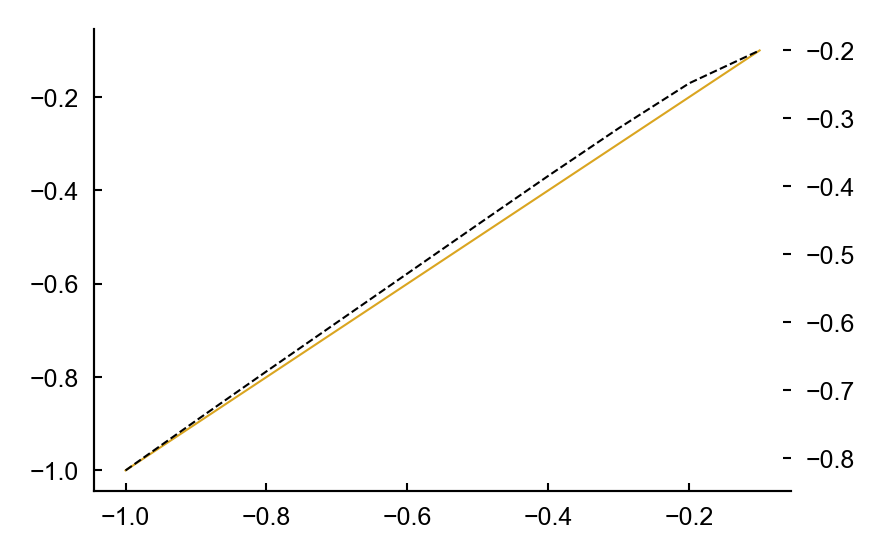

In [37]:
ax = plt.gca()
ax.plot(lams, lams, c='goldenrod')
ax2 = ax.twinx()
ax2.plot(lams, stab_means, linestyle='--', c='k')

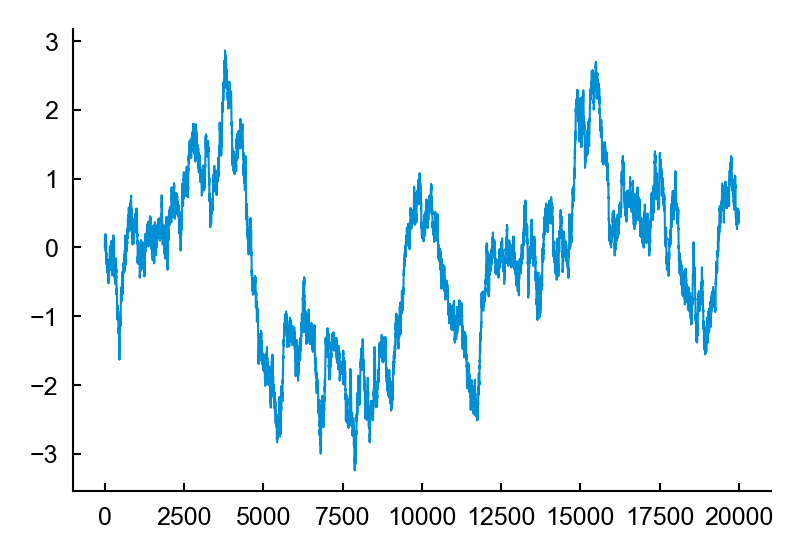

In [64]:
plt.plot(signals[-0.1][:, 0])

# Linear Demo 2

In [52]:
def do_one_sde_freq_run(n, decay_rate, freq, dt, scale=1, random_seed=42):

    np.random.seed(random_seed)

    A = np.random.normal(0,1/np.sqrt(n),(n,n))
    A = set_smallest_eigenvalue_real_part(A,-decay_rate)

    return A

    # Lambda = np.zeros((n, n))
    # Lambda[:2][:, :2] = np.array([[-decay_rate, freq*2*np.pi], [-freq*2*np.pi, -decay_rate]])
    # # max_decay = -20*decay_rate
    # # min_decay = -30*decay_rate
    # max_decay = -100*decay_rate
    # min_decay = -1000*decay_rate
    # extra_decay_rates = np.random.uniform(min_decay, max_decay, size=int((n - 2)/2))
    # extra_freqs = np.random.uniform(0.5, 40, size=int((n - 2)/2))
    # for i in range(1, int((n - 2)/2)+1):
    #     Lambda[2*i:2*i + 2][:, 2*i:2*i + 2] = np.array([[extra_decay_rates[i-1], extra_freqs[i-1]*2*np.pi], [-extra_freqs[i-1]*2*np.pi, extra_decay_rates[i-1]]])
    
    # V = np.random.randn(Lambda.shape[-1], Lambda.shape[-1])*(1/np.sqrt(n))
    # # V = np.eye(Lambda.shape[-1])
    
    # A = V @ Lambda @ np.linalg.inv(V)

    # Define the Weiner process    
    dW = np.sqrt(dt) * np.random.randn(N,n)

    # Define the function f(x)
    def f(x,lam):
        return A @ x

    # Define the function g(x)
    def g(x):
        return scale

    # Initialize the x array
    x = np.zeros((N,n))
    x[0] = np.zeros(n)

    # Simulate the stochastic differential equation
    for i in range(1, N):
        x[i] = x[i-1] + f(x[i-1],lam) * dt + g(x[i-1]) * dW[i]

    return x

In [53]:
lam = 0.01
freq = 4

N = 20000
n = 100
T = 40.0
dt = T / N

scale = 1

In [54]:
A = do_one_sde_freq_run(n, lam, freq, dt, scale, random_seed=42)

In [55]:
evals = np.linalg.eigvals(A)

In [57]:
dr = np.real(evals)
f = np.imag(evals)/(2*np.pi)

(array([ 6.,  9., 11., 10.,  8., 20., 10., 11.,  9.,  6.]),
 array([-0.15457254, -0.12365803, -0.09274352, -0.06182902, -0.03091451,
         0.        ,  0.03091451,  0.06182902,  0.09274352,  0.12365803,
         0.15457254]),
 <BarContainer object of 10 artists>)

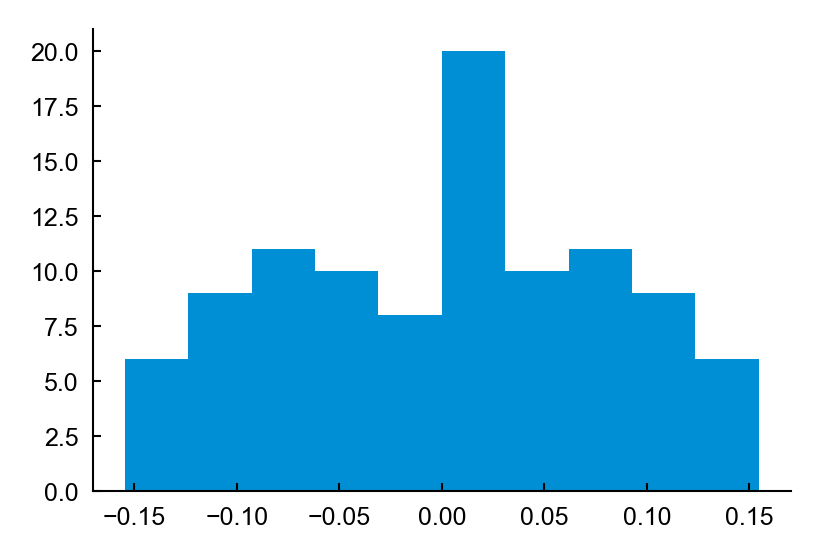

In [58]:
plt.hist(f)

(array([ 6.,  8., 12., 10., 12., 14., 12., 10.,  7.,  9.]),
 array([-1.95040239, -1.75636215, -1.56232191, -1.36828167, -1.17424144,
        -0.9802012 , -0.78616096, -0.59212072, -0.39808048, -0.20404024,
        -0.01      ]),
 <BarContainer object of 10 artists>)

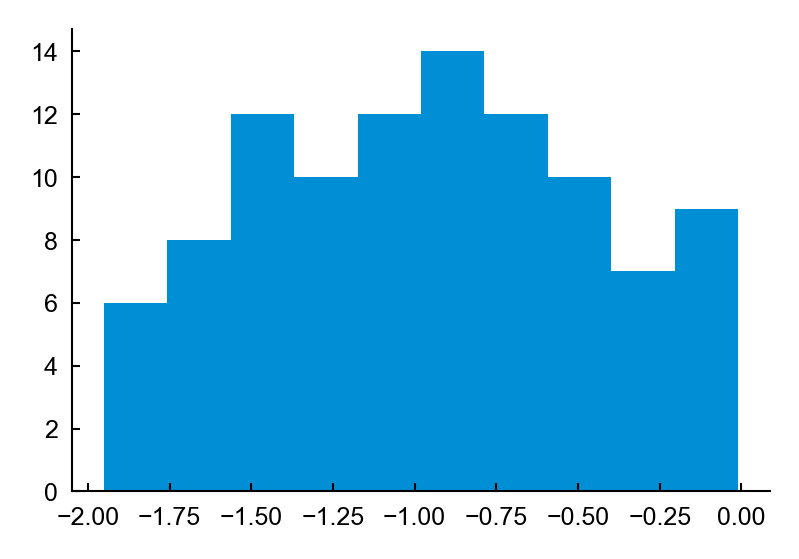

In [59]:
plt.hist(dr)

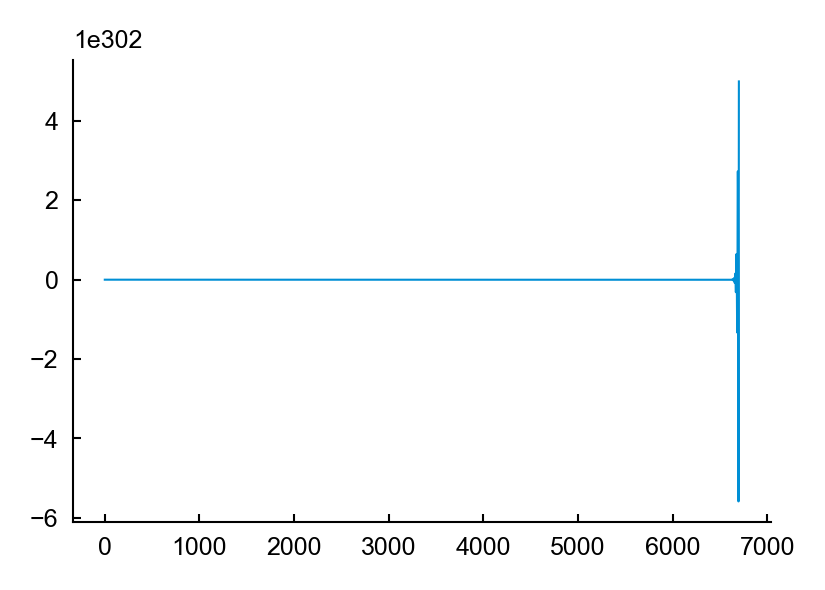

In [41]:
plt.plot(x[:, 0])